In [234]:
### IMPORTING LIBRARIES
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.tseries.offsets import DateOffset
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")



In [235]:
### LOADING THE DATA
flights = sns.load_dataset("flights")
flights

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121
...,...,...,...
139,1960,Aug,606
140,1960,Sep,508
141,1960,Oct,461
142,1960,Nov,390


In [236]:
### CHECKING MISSING VALUES
flights.isnull().sum()

year          0
month         0
passengers    0
dtype: int64

In [237]:
flights.tail()

,year,month,passengers
139,1960,Aug,606
140,1960,Sep,508
141,1960,Oct,461
142,1960,Nov,390
143,1960,Dec,432


In [238]:
### MONTH MAPPING
month_mapping = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

flights['month_num'] = flights['month'].map(month_mapping)

In [239]:
### CONCATENATING YEAR AND MONTH TOGETHER IN A SINGLE COLUMN
flights['date'] = pd.to_datetime(flights['year'].astype(str) + '-' + flights['month_num'].astype(str), format='%Y-%m')

In [240]:
### DATE COLUMN IS SET AS INDEX IN THE DATA
flights.set_index('date', inplace=True)
flights.head()

,year,month,passengers,month_num
date,,,,
1949-01-01,1949,Jan,112,1
1949-02-01,1949,Feb,118,2
1949-03-01,1949,Mar,132,3
1949-04-01,1949,Apr,129,4
1949-05-01,1949,May,121,5


In [241]:
### DROPPING THE UNNECESSARY COLUMNS
flights.drop(['year', 'month', 'month_num'], axis = 1, inplace = True)
flights.head()

,passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [242]:
### SUMMARY STATISTICS
flights.describe()

,passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


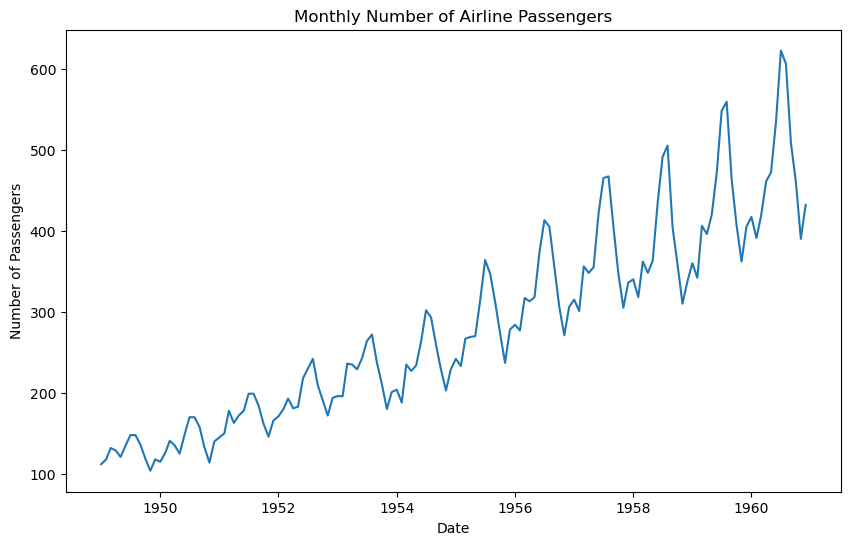

In [243]:
### VISUALIZING THE TIME SERIES DATA
plt.figure(figsize=(10, 6))
plt.plot(flights['passengers'])
plt.title('Monthly Number of Airline Passengers')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.show()

In [244]:
### TESTING FOR STATIONARITY USING AUGMENTED DICKEY FULLER TEST 
### H0: IT IS NOT STATIONARY
### H1: IT IS STATIONARY

def test_stationarity(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] < 0.05:
        print("The time series is likely stationary (p-value < 0.05).")
    else:
        print("The time series is likely non-stationary (p-value >= 0.05).")
        
### APPLYING ADFULLER TEST TO OUR SERIES
test_stationarity(flights['passengers'])

ADF Statistic: 0.8153688792060547
p-value: 0.9918802434376411
The time series is likely non-stationary (p-value >= 0.05).


In [245]:
### FIRST DIFFERENCING FOR MAKING IT STATIONARY
flights['passengers_1_difference'] = flights['passengers'] - flights['passengers'].shift(1)
flights.head()

,passengers,passengers_1_difference
date,,
1949-01-01,112,NaN
1949-02-01,118,6.0
1949-03-01,132,14.0
1949-04-01,129,-3.0
1949-05-01,121,-8.0


In [246]:
### APPLYING ADFULLER TEST TO PASSENGERS FIRST DIFFERENCE TO CHECK STATIONARITY
test_stationarity(flights['passengers_1_difference'].dropna())

ADF Statistic: -2.829266824170004
p-value: 0.05421329028382491
The time series is likely non-stationary (p-value >= 0.05).


In [247]:
### SECOND DIFFERENCING TO MAKE IT STATIONARY DATA
flights['passengers_2_difference'] = flights['passengers_1_difference'] - flights['passengers_1_difference'].shift(1)
flights.head()

,passengers,passengers_1_difference,passengers_2_difference
date,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,6.0,NaN
1949-03-01,132,14.0,8.0
1949-04-01,129,-3.0,-17.0
1949-05-01,121,-8.0,-5.0


In [248]:
### APPLYING ADFULLER TEST TO PASSENGERS SECOND DIFFERENCE TO CHECK STATIONARITY
test_stationarity(flights['passengers_2_difference'].dropna())

ADF Statistic: -16.38423154246853
p-value: 2.732891850014085e-29
The time series is likely stationary (p-value < 0.05).


<Figure size 1000x800 with 0 Axes>

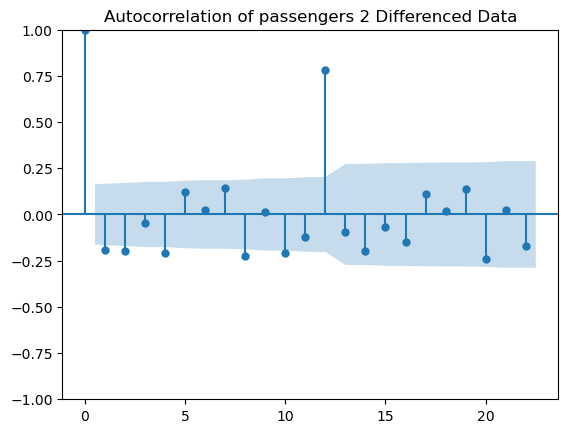

In [249]:
### AUTOCORRELATION OF PASSENGERS SECOND DIFFERENCE
plt.figure(figsize=(10, 8))
plot_acf(flights['passengers_2_difference'].dropna())
plt.title('Autocorrelation of passengers 2 Differenced Data')
plt.show()

<Figure size 1000x600 with 0 Axes>

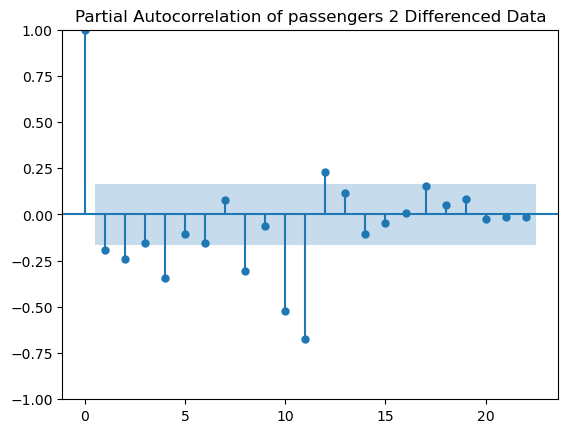

In [250]:
### PARTIAL AUTOCORRELATION OF PASSENGERS SECOND DIFFERENCE
plt.figure(figsize=(10, 6))
plot_pacf(flights['passengers_2_difference'].dropna())
plt.title('Partial Autocorrelation of passengers 2 Differenced Data')
plt.show()

In [251]:
### TO MAKE IT STATIONARY WE PERFORM SEASONAL DIFFERENCING METHOD APPROACH
flights['seasonal_12_difference'] = flights['passengers'] - flights['passengers'].shift(12)
flights.head(15)

,passengers,passengers_1_difference,passengers_2_difference,seasonal_12_difference
date,,,,
1949-01-01,112,NaN,NaN,NaN
1949-02-01,118,6.0,NaN,NaN
1949-03-01,132,14.0,8.0,NaN
1949-04-01,129,-3.0,-17.0,NaN
1949-05-01,121,-8.0,-5.0,NaN
1949-06-01,135,14.0,22.0,NaN
1949-07-01,148,13.0,-1.0,NaN
1949-08-01,148,0.0,-13.0,NaN
1949-09-01,136,-12.0,-12.0,NaN


In [252]:
### APPLYING ADFULLER TEST TO SEASONAL FIRST DIFFERENCE TO CHECK STATIONARITY
test_stationarity(flights['seasonal_12_difference'].dropna())

ADF Statistic: -3.3830207264924814
p-value: 0.011551493085514952
The time series is likely stationary (p-value < 0.05).


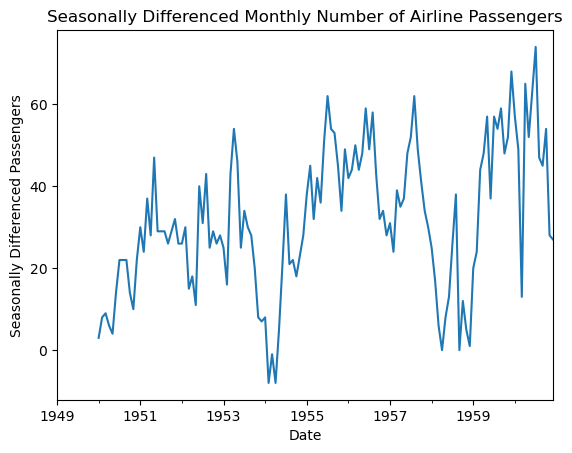

In [253]:
### NOW, IT HAS BECOME STATIONARY LETS PLOT IT
flights['seasonal_12_difference'].plot()
plt.title('Seasonally Differenced Monthly Number of Airline Passengers')
plt.xlabel('Date')
plt.ylabel('Seasonally Differenced Passengers')
plt.show()
plt.show()

<Figure size 1000x600 with 0 Axes>

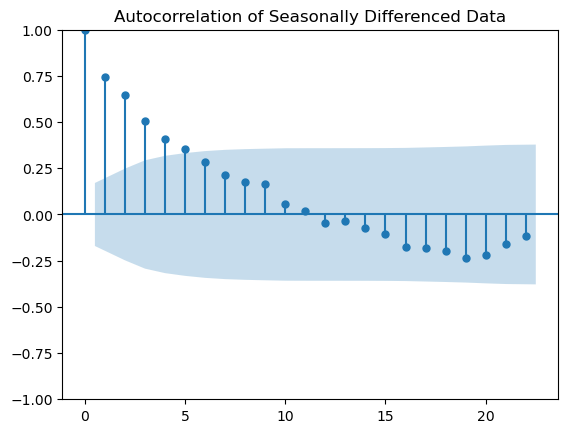

In [254]:
### AUTOCORRELATION PLOT FOR SEASONAL DIFFERENCING 
plt.figure(figsize=(10, 6))
plot_acf(flights['seasonal_12_difference'].dropna())
plt.title('Autocorrelation of Seasonally Differenced Data')
plt.show()

<Figure size 1000x600 with 0 Axes>

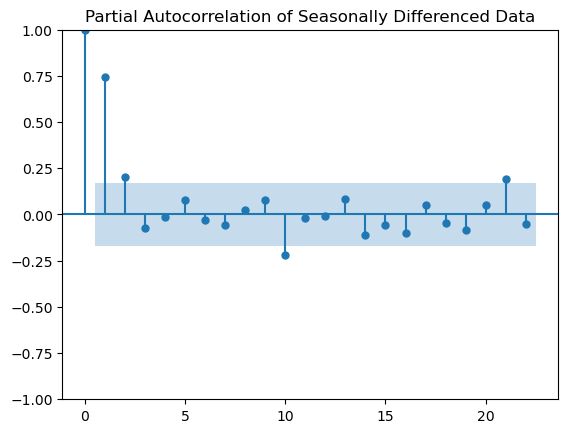

In [255]:
### PLOTTING THE PARTIAL AUTOCORRELATION PLOT FOR SEASONAL DIFFERENCING
plt.figure(figsize=(10, 6))
plot_pacf(flights['seasonal_12_difference'].dropna())
plt.title('Partial Autocorrelation of Seasonally Differenced Data')
plt.show()

In [256]:
### USING TRAIN TEST DATA SPLITTING METHOD
train_data_end = datetime(1958,12,1)
test_data_end = datetime(1960,12,1)

### GENERATING TRAIN AND TEST DATA
train_data = flights[:train_data_end]
test_data = flights[train_data_end + timedelta(days = 1):test_data_end]

In [257]:
### PREDICTION
pred_data_start = test_data.index[0]
pred_data_end = test_data.index[-1]
print(pred_data_start)
print(pred_data_end)

1959-01-01 00:00:00
1960-12-01 00:00:00


In [258]:
test_data

,passengers,passengers_1_difference,passengers_2_difference,seasonal_12_difference
date,,,,
1959-01-01,360,23.0,-4.0,20.0
1959-02-01,342,-18.0,-41.0,24.0
1959-03-01,406,64.0,82.0,44.0
1959-04-01,396,-10.0,-74.0,48.0
1959-05-01,420,24.0,34.0,57.0
1959-06-01,472,52.0,28.0,37.0
1959-07-01,548,76.0,24.0,57.0
1959-08-01,559,11.0,-65.0,54.0
1959-09-01,463,-96.0,-107.0,59.0


In [259]:
### IMPLEMENTING ARIMA FOR TEST DATA PREDICTION
mod_arima = ARIMA(train_data['passengers'], order = (10,2,0))
mod_arima_fit = mod_arima.fit()
mod_arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             passengers   No. Observations:                  120
Model:                ARIMA(10, 2, 0)   Log Likelihood                -533.414
Date:                Wed, 05 Mar 2025   AIC                           1088.827
Time:                        22:42:37   BIC                           1119.305
Sample:                    01-01-1949   HQIC                          1101.202
                         - 12-01-1958                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4125      0.093     -4.422      0.000      -0.595      -0.230
ar.L2         -0.7276      0.084     -8.665      0.000      -0.892      -0.563
ar.L3         -0.3705      0.081     -4.572      0.000      -0.529      -0.212
ar.L4         -0.7915      0.103     -7.680      0.000      -0.994      -0.590
ar.L5         -0.3854      0.131     -2.941      0.003      -0.642      -0.129
ar.L6         -0.6453      0.104     -6.201      0.000      -0.849      -0.441
ar.L7         -0.2216      0.122     -1.820      0.069      -0.460       0.017
ar.L8         -0.6971      0.126     -5.534      0.000      -0.944      -0.450
ar.L9         -0.2800      0.107     -2.627      0.009      -0.489      -0.071
ar.L10        -0.6227      0.084     -7.411      0.000      -0.787      -0.458
sigma2       462.5022     83.870      5.515      0.000     298.121     626.884
===================================================================================
Ljung-Box (L1) (Q):                  27.93   Jarque-Bera (JB):                 1.30
Prob(Q):                              0.00   Prob(JB):                         0.52
Heteroskedasticity (H):               3.48   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [260]:
### ARIMA PREDICTION BASED ON TEST DATA
pred_arima = mod_arima_fit.predict(start = pred_data_start, end = pred_data_end)

### RESIDUALS
res = test_data['passengers'] - pred_arima
res


date
1959-01-01    -14.638368
1959-02-01    -30.981906
1959-03-01     12.128455
1959-04-01     36.902495
1959-05-01     20.204345
1959-06-01     32.336733
1959-07-01     70.092713
1959-08-01     97.902873
1959-09-01     64.844737
1959-10-01     32.516318
1959-11-01     19.530208
1959-12-01     17.601968
1960-01-01     17.000506
1960-02-01    -18.742111
1960-03-01     15.524858
1960-04-01     76.586339
1960-05-01     47.461860
1960-06-01     92.770047
1960-07-01    150.008737
1960-08-01    165.287885
1960-09-01     98.618446
1960-10-01     73.110400
1960-11-01      9.180697
1960-12-01     11.131076
dtype: float64

<Axes: ylabel='Density'>

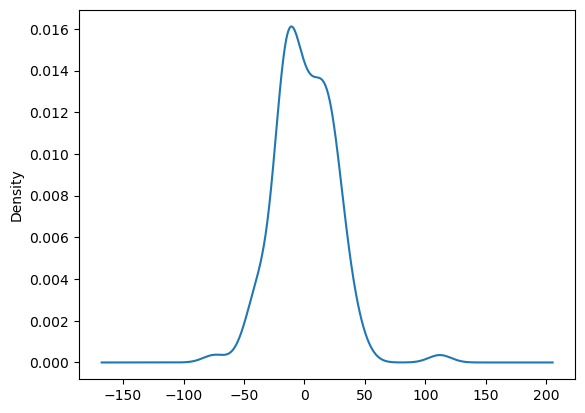

In [261]:
### PLOTTING THE RESIDUES
mod_arima_fit.resid.plot(kind = 'kde')

<Axes: xlabel='date'>

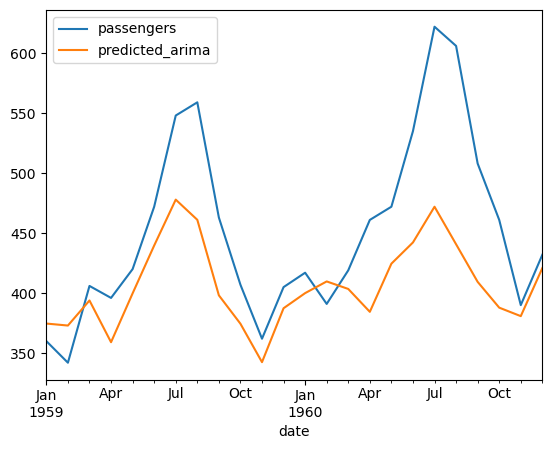

In [262]:
### PLOTTING THE ARIMA PREDICTIONS AND ACTAUL POINTS
test_data['predicted_arima'] = pred
test_data[['passengers', 'predicted_arima']].plot()

In [263]:
### IMPLEMENTING SARIMAX FOR TEST DATA PREDICTION
mod_sarimax = SARIMAX(train_data['passengers'], 
                        order=(3,0,5),  ## (Non Seasonal ARIMA)
                        seasonal_order=(0, 1, 0, 12))  ## (Seasonal ARIMA)
mod_sarimax_fit = mod_sarimax.fit()


mod_sarimax_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          passengers   No. Observations:                  120
Model:             SARIMAX(3, 0, 5)x(0, 1, [], 12)   Log Likelihood                -400.033
Date:                             Wed, 05 Mar 2025   AIC                            818.065
Time:                                     22:42:37   BIC                            842.205
Sample:                                 01-01-1949   HQIC                           827.853
                                      - 12-01-1958                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0633      0.812     -0.078      0.938      -1.655       1.528
ar.L2          0.3284      0.657      0.500      0.617      -0.960       1.617
ar.L3          0.6761      0.501      1.350      0.177      -0.305       1.658
ma.L1          0.7983      0.812      0.983      0.326      -0.793       2.390
ma.L2          0.5287      0.447      1.183      0.237      -0.347       1.404
ma.L3         -0.2936      0.195     -1.506      0.132      -0.676       0.088
ma.L4         -0.2754      0.225     -1.222      0.222      -0.717       0.166
ma.L5         -0.2129      0.250     -0.851      0.395      -0.703       0.277
sigma2        93.4593     11.987      7.797      0.000      69.966     116.953
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.04
Prob(Q):                              0.95   Prob(JB):                         0.36
Heteroskedasticity (H):               1.42   Skew:                             0.05
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [264]:
### SARIMAX PREDICTION BASED ON TEST DATA
pred_sar = mod_sarimax_fit.predict(start = pred_data_start, end = pred_data_end)

### RESIDUALS
res_SAR = test_data['passengers'] - pred_sar
res_SAR

date
1959-01-01     12.806180
1959-02-01     20.669529
1959-03-01     39.809151
1959-04-01     39.996472
1959-05-01     51.833288
1959-06-01     31.864829
1959-07-01     50.216660
1959-08-01     49.249443
1959-09-01     53.600750
1959-10-01     42.195077
1959-11-01     47.382145
1959-12-01     62.735146
1960-01-01     64.697877
1960-02-01     65.141436
1960-03-01     47.858283
1960-04-01    100.368784
1960-05-01     99.438586
1960-06-01     90.275667
1960-07-01    119.934845
1960-08-01     92.041832
1960-09-01     94.357905
1960-10-01     92.186643
1960-11-01     71.397470
1960-12-01     85.802135
dtype: float64

<Axes: ylabel='Density'>

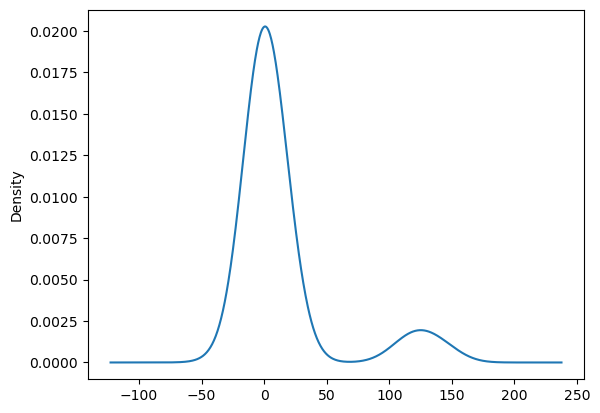

In [265]:
### PLOTTING THE RESIDUES
mod_sarimax_fit.resid.plot(kind = 'kde')

<Axes: xlabel='date'>

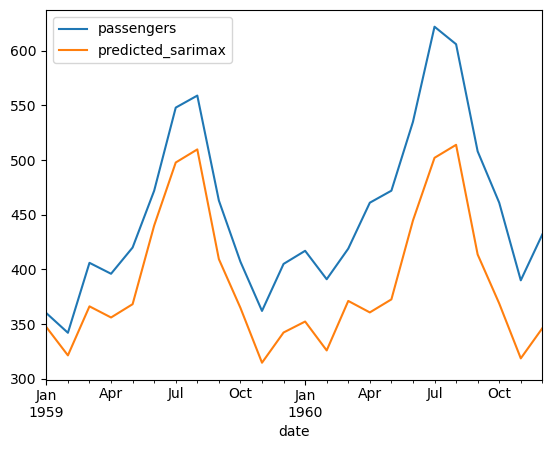

In [266]:
### PLOTTING THE SARIMAX PREDICTIONS AND ACTUAL POINTS 
test_data['predicted_sarimax'] = pred_sar
test_data[['passengers', 'predicted_sarimax']].plot()

<Axes: xlabel='date'>

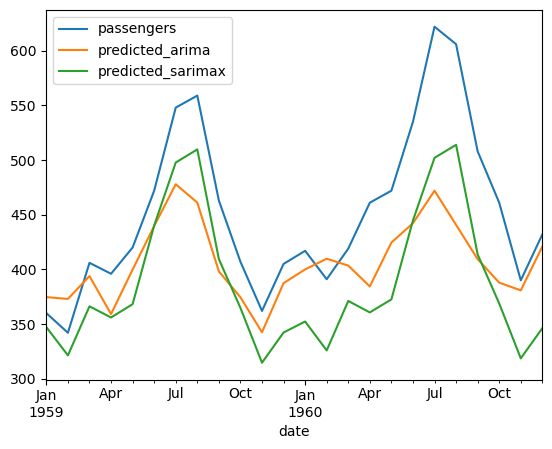

In [267]:
### PLOTTING THE ARIMA PREDICTIONS, SARIMAX PREDICTIONS AND THE ACTUAL POINTS
test_data[['passengers', 'predicted_arima', 'predicted_sarimax']].plot()

In [268]:
### MODEL EVALUATION
arima_mse = mean_squared_error(test_data['passengers'], pred_arima )
sarimax_mse = mean_squared_error(test_data['passengers'], pred_sar)

### COMPARING THE AIC AND BIC MEASURES
arima_aic, arima_bic = mod_arima_fit.aic, mod_arima_fit.bic
sarimax_aic, sarimax_bic = mod_sarimax_fit.aic, mod_sarimax_fit.bic

print('ARIMA_MSE', arima_mse)
print('\nSARIMAX_MSE', sarimax_mse)
print('\nARIMA_AIC:',arima_aic, 'and ARIMA_BIC:', arima_bic)
print('\nSARIMAX_AIC:', sarimax_aic, 'and SARIMAX_BIC:', sarimax_bic)



ARIMA_MSE 4470.650276224042

SARIMAX_MSE 4783.6643267379995

ARIMA_AIC: 1088.8271433624939 and ARIMA_BIC: 1119.3046742316162

SARIMAX_AIC: 818.0653920168038 and SARIMAX_BIC: 842.2045730609218


In [269]:
### IMPLEMENTING ARIMA MODEL FOR PERFORMING INLINE PREDICTION
arima_model = ARIMA(flights['passengers'], order=(1, 1, 1))  ## p = d = q = 1
arima_fit = arima_model.fit()
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             passengers   No. Observations:                  144
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -694.341
Date:                Wed, 05 Mar 2025   AIC                           1394.683
Time:                        22:42:38   BIC                           1403.571
Sample:                    01-01-1949   HQIC                          1398.294
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4742      0.123     -3.847      0.000      -0.716      -0.233
ma.L1          0.8635      0.078     11.051      0.000       0.710       1.017
sigma2       961.9270    107.433      8.954      0.0

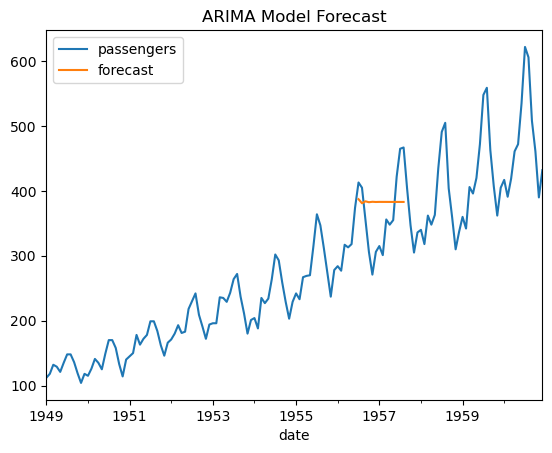

In [270]:
### FORECASTING FROM ARIMA
flights['forecast'] = arima_fit.predict(start = 90, end = 103, dynamic = True)
flights[['passengers', 'forecast']].plot()
plt.title('ARIMA Model Forecast')
plt.legend()
plt.show()

In [271]:
### IMPLEMENTING THE SARIMAX MODEL FOR INLINE PREDICTION

sarimax_model = SARIMAX(flights['passengers'], 
                        order=(1, 1, 1),  ## p = d = q = 1 (Non Seasonal ARIMA)
                        seasonal_order=(1, 1, 1, 12))  ## p = d = q = 1 and s = 12 (Seasonal ARIMA)
sarimax_fit = sarimax_model.fit()


print(sarimax_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         passengers   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -506.149
Date:                            Wed, 05 Mar 2025   AIC                           1022.299
Time:                                    22:42:38   BIC                           1036.675
Sample:                                01-01-1949   HQIC                          1028.140
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1272      0.356     -0.358      0.721      -0.825       0.570
ma.L1         -0.2148      0.325   

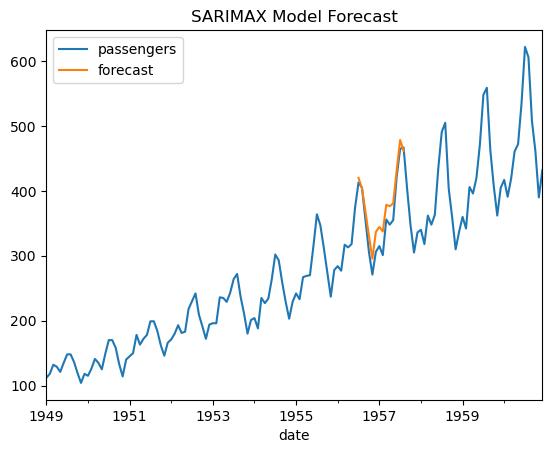

In [272]:
### FORECASTING FROM SARIMAX
flights['forecast'] = sarimax_fit.predict(start = 90, end = 103, dynamic = True)
flights[['passengers', 'forecast']].plot()
plt.title('SARIMAX Model Forecast')
plt.legend()
plt.show()

In [273]:
### COMPARING THE AIC AND BIC MEASURES
arima_aic, arima_bic = arima_fit.aic, arima_fit.bic
sarimax_aic, sarimax_bic = sarimax_fit.aic, sarimax_fit.bic

print('\nARIMA_AIC:',arima_aic, 'and ARIMA_BIC:', arima_bic)
print('\nSARIMAX_AIC:', sarimax_aic, 'and SARIMAX_BIC:', sarimax_bic)



ARIMA_AIC: 1394.682505325338 and ARIMA_BIC: 1403.5710392161177

SARIMAX_AIC: 1022.2987916879536 and SARIMAX_BIC: 1036.6747783039593


In [274]:
### OUTLINE PREDICTION GETTING MORE ADDITIONAL FUTURE DATES TO PERFORM FORECASTING USING SARIMAX
future_dates = [flights.index[-1] + DateOffset(months = x) for x in range(0,24)]
future_df = pd.DataFrame(index = future_dates[1:], columns = flights.columns)
future_df.tail()

,passengers,passengers_1_difference,passengers_2_difference,seasonal_12_difference,forecast
1962-07-01,NaN,NaN,NaN,NaN,NaN
1962-08-01,NaN,NaN,NaN,NaN,NaN
1962-09-01,NaN,NaN,NaN,NaN,NaN
1962-10-01,NaN,NaN,NaN,NaN,NaN
1962-11-01,NaN,NaN,NaN,NaN,NaN


In [275]:
future_df = pd.concat([flights, future_df])
future_df.head(15)

,passengers,passengers_1_difference,passengers_2_difference,seasonal_12_difference,forecast
1949-01-01,112,NaN,NaN,NaN,NaN
1949-02-01,118,6.0,NaN,NaN,NaN
1949-03-01,132,14.0,8.0,NaN,NaN
1949-04-01,129,-3.0,-17.0,NaN,NaN
1949-05-01,121,-8.0,-5.0,NaN,NaN
1949-06-01,135,14.0,22.0,NaN,NaN
1949-07-01,148,13.0,-1.0,NaN,NaN
1949-08-01,148,0.0,-13.0,NaN,NaN
1949-09-01,136,-12.0,-12.0,NaN,NaN
1949-10-01,119,-17.0,-5.0,NaN,NaN


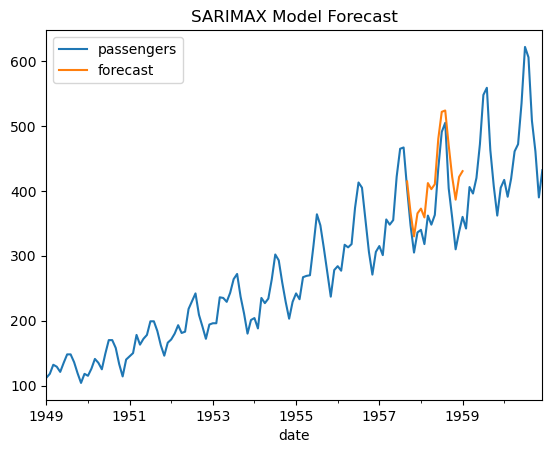

In [276]:
### ADDITIONAL DATA FORECASTING USING SARIMAX
flights['forecast'] = sarimax_fit.predict(start = 104, end = 120, dynamic = True)
flights[['passengers', 'forecast']].plot()
plt.title('SARIMAX Model Forecast')
plt.legend()
plt.show()

##### FOR TEST DATA PREDICTION, ARIMA IS PERFORMING BETTER CONSIDERING LOWER MSE VALUE, WHEREAS, 
##### SARIMAX PERFORMING BETTER CONSIDERING THE LOWER AIC AND BIC VALUE.

##### FOR INLINE PREDICTION, SARIMAX PERFORMING BETTER WITH LOWER AIC AND LOWER BIC VALUE.